In [2]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--2025-04-29 14:14:44--  https://raw.githubusercontent.com/sismetanin/rusentitweet/main/rusentitweet_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1348196 (1.3M) [text/plain]
Saving to: ‘rusentitweet_train.csv’

rusentitweet_train. 100%[===================>]   1.29M  --.-KB/s    in 0.01s   

2025-04-29 14:14:44 (86.5 MB/s) - ‘rusentitweet_train.csv’ saved [1348196/1348196]

--2025-04-29 14:14:44--  https://raw.githubusercontent.com/sismetanin/rusentitweet/main/rusentitweet_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 

Map:   0%|          | 0/10713 [00:00<?, ? examples/s]

Map:   0%|          | 0/2679 [00:00<?, ? examples/s]

Map:   0%|          | 0/10713 [00:00<?, ? examples/s]

Map:   0%|          | 0/2679 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10713 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2679 [00:00<?, ? examples/s]

Original - Size: 711.49 MB, Accuracy: 0.4950, Time: 91.29s


Pruned - Size: 711.49 MB, Accuracy: 0.4900, Time: 85.80s


Quantized - Size: 454.97 MB, Accuracy: 0.4150, Time: 61.45s


Epoch,Training Loss,Validation Loss,Accuracy
1,1.026500,1.020145,0.510000


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,0.523500,0.509224,0.510000


Distilled - Size: 213.42 MB, Accuracy: 0.5100, Time: 8.69s


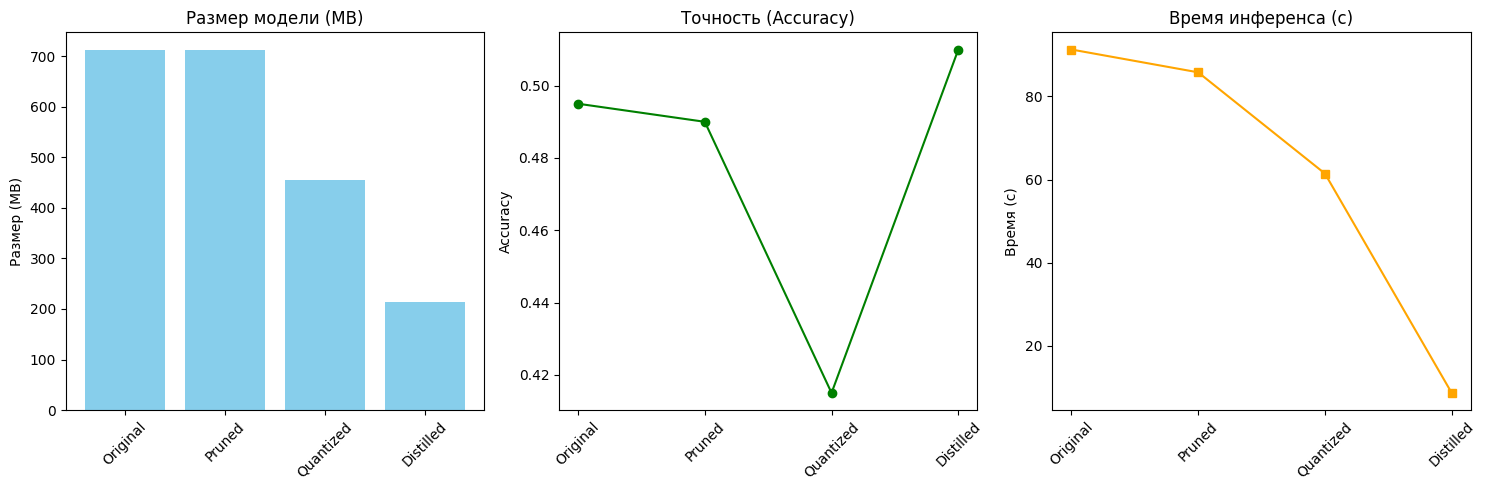


Результаты:
        Этап  Размер (MB)  Точность  Время (с)
0   Original   711.488377     0.495  91.288666
1     Pruned   711.488377     0.490  85.798440
2  Quantized   454.965333     0.415  61.451509
3  Distilled   213.424090     0.510   8.689367


In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.quantization
import torch.nn.utils.prune as prune
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertForSequenceClassification, DistilBertConfig
from transformers import Trainer, TrainingArguments
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datasets import Dataset, DatasetDict
import evaluate
import gc

# Установка необходимых библиотек
!pip install transformers datasets torch onnx evaluate
!pip install huggingface_hub[hf_xet]

# Отключение W&B для избежания запроса API-ключа
os.environ["WANDB_MODE"] = "offline"

# Загрузка модели и токенизатора для учителя
teacher_model_name = "DeepPavlov/rubert-base-cased"
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_model_name, num_labels=3)

# Загрузка токенизатора для ученика (совпадающего с учителем)
student_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)

# Создание конфигурации для ученической модели (меньшая DistilBERT)
student_config = DistilBertConfig(
    vocab_size=teacher_tokenizer.vocab_size,
    num_labels=3,
    n_layers=4,        # Уменьшено до 4 слоев
    n_heads=6,         # Уменьшено количество attention heads
    dim=384,           # Уменьшен размер эмбеддингов
    hidden_dim=1536,   # Уменьшен скрытый слой
    dropout=0.1,
    attention_dropout=0.1
)

# Создание ученической модели с нуля
student_model = DistilBertForSequenceClassification(student_config)

# Скачивание датасета RuSentiTweet с GitHub
!wget https://raw.githubusercontent.com/sismetanin/rusentitweet/main/rusentitweet_train.csv -O rusentitweet_train.csv
!wget https://raw.githubusercontent.com/sismetanin/rusentitweet/main/rusentitweet_test.csv -O rusentitweet_test.csv

# Загрузка CSV в pandas DataFrame
train_df = pd.read_csv("rusentitweet_train.csv")
test_df = pd.read_csv("rusentitweet_test.csv")

# Создание датасета из DataFrame
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

# Функция токенизации
def tokenize_function(examples):
    return student_tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Функция маппинга меток
def map_labels(examples):
    label_map = {"positive": 0, "negative": 1, "neutral": 2, "speech": -1, "skip": -1}
    examples["label"] = label_map[examples["label"]]
    return examples

# Токенизация и фильтрация
tokenized_datasets = dataset.map(tokenize_function, batched=True).map(map_labels)
tokenized_datasets = tokenized_datasets.filter(lambda example: example["label"] != -1)

# Ограничение размера датасета для скорости
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(min(1000, len(tokenized_datasets["train"]))))
eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(min(200, len(tokenized_datasets["test"]))))

# Функция для оценки модели
metric = evaluate.load("accuracy")
def evaluate_model(model, dataset):
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="./results",
            per_device_eval_batch_size=4,  # Уменьшено
            do_eval=True,
            report_to="none",
            run_name=f"eval_{int(time.time())}"
        ),
        eval_dataset=dataset,
        compute_metrics=lambda eval_pred: metric.compute(
            predictions=np.argmax(eval_pred.predictions, axis=1),
            references=eval_pred.label_ids
        )
    )
    start_time = time.time()
    metrics = trainer.evaluate()
    inference_time = time.time() - start_time
    torch.cuda.empty_cache()
    gc.collect()
    return metrics["eval_accuracy"], inference_time

# Функция для получения размера модели
def get_model_size(model):
    torch.save(model.state_dict(), "temp.pt")
    size = os.path.getsize("temp.pt") / 1e6
    os.remove("temp.pt")
    return size

# Инициализация списков для графиков
sizes = []
accuracies = []
inference_times = []
stages = ["Original"]

# Оценка исходной модели (учителя)
teacher_model.eval()
original_size = get_model_size(teacher_model)
original_accuracy, original_time = evaluate_model(teacher_model, eval_dataset)
sizes.append(original_size)
accuracies.append(original_accuracy)
inference_times.append(original_time)
print(f"Original - Size: {original_size:.2f} MB, Accuracy: {original_accuracy:.4f}, Time: {original_time:.2f}s")

# 1. Прунинг
def apply_pruning(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')
    return model

teacher_model = apply_pruning(teacher_model, amount=0.3)
pruned_size = get_model_size(teacher_model)
pruned_accuracy, pruned_time = evaluate_model(teacher_model, eval_dataset)
sizes.append(pruned_size)
accuracies.append(pruned_accuracy)
inference_times.append(pruned_time)
stages.append("Pruned")
print(f"Pruned - Size: {pruned_size:.2f} MB, Accuracy: {pruned_accuracy:.4f}, Time: {pruned_time:.2f}s")

# 2. Квантование
quantized_model = torch.quantization.quantize_dynamic(teacher_model, {torch.nn.Linear}, dtype=torch.qint8)
quantized_size = get_model_size(quantized_model)
quantized_accuracy, quantized_time = evaluate_model(quantized_model, eval_dataset)
sizes.append(quantized_size)
accuracies.append(quantized_accuracy)
inference_times.append(quantized_time)
stages.append("Quantized")
print(f"Quantized - Size: {quantized_size:.2f} MB, Accuracy: {quantized_accuracy:.4f}, Time: {quantized_time:.2f}s")

# 3. Полноценная дистилляция

# Предварительное обучение учителя
training_args = TrainingArguments(
    output_dir="./teacher_results",
    per_device_train_batch_size=4,  # Уменьшено
    per_device_eval_batch_size=4,   # Уменьшено
    num_train_epochs=1,             # Уменьшено для отладки
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    run_name=f"teacher_{int(time.time())}",
    fp16=False,                     # Отключено для стабильности
    logging_steps=10,               # Логирование каждые 10 шагов
)

teacher_trainer = Trainer(
    model=teacher_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=lambda eval_pred: metric.compute(
        predictions=np.argmax(eval_pred.predictions, axis=1),
        references=eval_pred.label_ids
    )
)
teacher_trainer.train()

# Кастомный Trainer для дистилляции
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, temperature=2.0, alpha=0.5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.teacher_model.eval()
        self.teacher_model.to("cuda" if torch.cuda.is_available() else "cpu")
        self.temperature = temperature
        self.alpha = alpha

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits
        loss_ce = student_outputs.loss

        with torch.no_grad():
            teacher_outputs = self.teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        student_probs = F.softmax(student_logits / self.temperature, dim=-1)
        teacher_probs = F.softmax(teacher_logits / self.temperature, dim=-1)

        loss_kl = F.kl_div(
            torch.log(student_probs),
            teacher_probs,
            reduction="batchmean"
        ) * (self.temperature ** 2)

        loss = self.alpha * loss_ce + (1 - self.alpha) * loss_kl
        return (loss, student_outputs) if return_outputs else loss

# Настройка параметров обучения для дистилляции
training_args = TrainingArguments(
    output_dir="./distil_results",
    per_device_train_batch_size=4,  # Уменьшено
    per_device_eval_batch_size=4,   # Уменьшено
    num_train_epochs=1,             # Уменьшено для отладки
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    run_name=f"distil_{int(time.time())}",
    fp16=False,                     # Отключено для стабильности
    logging_steps=10,               # Логирование каждые 10 шагов
)

# Создание DistillationTrainer
trainer = DistillationTrainer(
    model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=lambda eval_pred: metric.compute(
        predictions=np.argmax(eval_pred.predictions, axis=1),
        references=eval_pred.label_ids
    ),
    temperature=2.0,
    alpha=0.5
)

# Обучение с дистилляцией
trainer.train()

# Оценка ученика
distilled_size = get_model_size(student_model)
distilled_accuracy, distilled_time = evaluate_model(student_model, eval_dataset)
sizes.append(distilled_size)
accuracies.append(distilled_accuracy)
inference_times.append(distilled_time)
stages.append("Distilled")
print(f"Distilled - Size: {distilled_size:.2f} MB, Accuracy: {distilled_accuracy:.4f}, Time: {distilled_time:.2f}s")

# Построение графиков
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(stages, sizes, color='skyblue')
plt.title("Размер модели (MB)")
plt.ylabel("Размер (MB)")
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.plot(stages, accuracies, marker='o', color='green')
plt.title("Точность (Accuracy)")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.plot(stages, inference_times, marker='s', color='orange')
plt.title("Время инференса (с)")
plt.ylabel("Время (с)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("optimization_results.png")
plt.show()

# Сохранение результатов в CSV
import pandas as pd
results = {
    "Этап": stages,
    "Размер (MB)": sizes,
    "Точность": accuracies,
    "Время (с)": inference_times
}
df = pd.DataFrame(results)
df.to_csv("optimization_metrics.csv", index=False)
print("\nРезультаты:")
print(df)

In [2]:
!cat rusentitweet_test.csv | wc -l

3133


In [3]:
time_dict = {'Оригинал': 91.288666, 'Пруннинг': 85.798440, 
             'Квантизация INT8': 61.451509, 'Дистилляция': 8.689367}

In [9]:
[print(f'{k}: {v / 3133 :5f}') for k, v in time_dict.items()];

Оригинал: 0.029138
Пруннинг: 0.027385
Квантизация INT8: 0.019614
Дистилляция: 0.002773
